In [1]:
import sys
import ete3
import os
from os import walk
sys.path.insert(0,'../scripts/')
from classDeclarationsAndFunctions import RootedTree
from fileIO import ReadRootedTree
from MarkovModels import GenerateQForStationaryDistribution, Get11FreeRates
from math import floor, ceil
from config import projectPath
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# scripts for submitting to server 

# run tools
# iqtree
import numpy as np
# iqtree_script = open("../batch_scripts/iqtree_scalability.sh","w")
# mstbackbone_script = open("../batch_scripts/mstbackbone_scalability.sh","w")
# fasttree_script = open("../batch_scripts/fastree_scalability.sh","w")
# raxml_script = open("../batch_scripts/raxml_scalability.sh","w")
data_path = projectPath + "data/"
tools_path_geniux = "/project/exaptation/Tools/"
num_trees_simulated = 0 
for seq_len in [1000,2000,5000,10000]:
    iqtree_script = open("../batch_scripts/iqtree_scalability_"+str(seq_len)+".sh","w")
    mstbackbone_script = open("../batch_scripts/mstbackbone_scalability_"+str(seq_len)+".sh","w")
    fasttree_script = open("../batch_scripts/fastree_scalability_"+str(seq_len)+".sh","w")
    raxml_script = open("../batch_scripts/raxml_scalability_"+str(seq_len)+".sh","w")    
    tree_id_num_leaves_scalability_file = open("../data/selected_grove_tree_ids_scalability","r")
    for line in tree_id_num_leaves_scalability_file:        
        tree_id = line.strip().split(',')[0].strip()
        num_leaves = int(line.strip().split(',')[1].strip())
        num_trees_simulated += 1
        print("Writing batch commands for tree ", str(num_trees_simulated))    
        mxqsub_prefix = ""
        exp_id = "treeId_"+tree_id+"_numLeaves_"+str(num_leaves)+"_seqLen_"+str(seq_len)
        exp_dir = data_path + "grove_exp/" + exp_id
        sequence_file_name = exp_dir + "/sequences_"+exp_id+".fas"                
        ###############        IQ-TREE      ##################
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N iqtree_scale\t"
        # mxqsub_prefix += " --stderr=err_iqtree_scalability_"+exp_id
        # mxqsub_prefix += " --stdout=out_iqtree_scalability_"+exp_id
        iqtree_command = tools_path_geniux + "iqtree2"
        iqtree_command += ' -s ' + sequence_file_name + ' -st DNA'
        iqtree_command += ' -nt ' + str(1)
        iqtree_command += ' -seed 1234'
        # iqtreeCommand += ' -quiet'
        iqtree_command += ' -redo'
        iqtree_command += ' -pre ' + sequence_file_name + "_iqtree2.0"
        iqtree_command += ' -m 12.12+FO'
        iqtree_script.write(mxqsub_prefix + iqtree_command + "\n")
        ###############     MST-BACKBONE     ###################
        # mst_backbone_command
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N mstbackbone_scale\t"
        # mxqsub_prefix += " --stderr=err_mstbackbone_scalability_" + exp_id
        # mxqsub_prefix += " --stdout=out_mstbackbone_scalability_" + exp_id
        mst_backbone_command = tools_path_geniux + "mst-backbone"
        mst_backbone_command += '\t--seq ' + sequence_file_name
        mst_backbone_command += '\t--out ' + exp_id
        mstbackbone_script.write(mxqsub_prefix + mst_backbone_command + "\n")
        ###############        RAxML-NG       ##################
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N raxmlng_scale\t"
        # mxqsub_prefix += " --stderr=err_raxmlng_scalability_" + exp_id
        # mxqsub_prefix += " --stdout=out_raxmlng_scalability_" + exp_id
        raxml_command = tools_path_geniux + "raxml-ng"
        fileNamePrefix = 'RAxMLNG_' + exp_id
        raxml_command += ' --tree pars{1}'
        raxml_command += ' --model GTR --msa ' + sequence_file_name
        raxml_command += ' --threads 1'
        # raxml_command += ' --redo '
        raxml_command += ' --tip-inner on --pat-comp on --site-repeats on'
        raxml_command += ' --prefix ' + fileNamePrefix
        raxml_script.write(mxqsub_prefix + raxml_command + "\n")
        #############          FastTree        ################
        # mxqsub_prefix = ""
        # mxqsub_prefix = "mxqsub -t 2d -m 1G -n -N fasttree_scale\t"
        # mxqsub_prefix += " --stderr=err_fasttree_scalability_"+exp_id
        # mxqsub_prefix += " --stdout=out_fasttree_scalability_"+exp_id
        output_tree_file_name = sequence_file_name + '.fasttree_newick'
        std_err_file_name = sequence_file_name + '.fasttree_errlog'
        fasttree_command = tools_path_geniux + 'FastTree'
        fasttree_command += ' -nt -nosupport -nocat -gtr < '+ sequence_file_name
        fasttree_command += ' > ' + output_tree_file_name
        fasttree_command += ' 2> ' + std_err_file_name
        fasttree_script.write(mxqsub_prefix + fasttree_command + "\n")
        ########################################################
    tree_id_num_leaves_scalability_file.close()
    raxml_script.close()
    fasttree_script.close()
    mstbackbone_script.close()
    iqtree_script.close()

In [58]:
# results list (count num of results)
run_time_num_taxa = {}
run_time_seq_length = {}
data_path = projectPath + "data/"
tools_path_geniux = "/project/exaptation/Tools/"
# method_list = ['mstbackbone','fasttree','iqtree','raxmlng']
method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
seqlen_list = [1000,2000,5000,10000]
def Check_results_file_names(method,exp_id):
    exp_dir = data_path + "grove_exp/" + exp_id
    sequence_file_name = exp_dir + "/sequences_" + exp_id + ".fas"
    if method == "raxmlng":
        log_file_name = projectPath + '/batch_scripts/RAxMLNG_' + exp_id + '.raxml.log'
        tree_file_name = projectPath + '/batch_scripts/RAxMLNG_' + exp_id + '.raxml.bestTree'
    elif method.startswith("mstbackbone"):
        # log_file_name = projectPath + '/batch_scripts/' + exp_id + '.mstbackbone_log'
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.newick'
    elif method == "fasttree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_errlog'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_newick'
    elif method == "iqtree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.log'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.treefile'
    if os.path.exists(log_file_name) and os.path.exists(tree_file_name):
        if os.path.getsize(log_file_name) > 0 and os.path.getsize(tree_file_name) > 0:
            return(True)
        else:
            return(False)
    else:
        return(False)

num_results = {}
for method in method_list:
    num_results[method] = 0

tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
for line in tree_id_num_leaves_scalability_file:
    tree_id = line.strip().split(',')[0].strip()
    num_leaves = int(line.strip().split(',')[1].strip())
    # num_trees_simulated += 1    
    for seq_len in seqlen_list:
        for method in method_list:            
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            if Check_results_file_names(method,exp_id):
                num_results[method] += 1

tree_id_num_leaves_scalability_file.close()

for method in method_list:
    print (num_results[method], "results available for ", method)
            # exp_dir = data_path + "grove_exp/" + exp_id
            # sequence_file_name = exp_dir + "/sequences_" + exp_id + ".fas"
            
            
            

460 results available for  fasttree
458 results available for  iqtree
105 results available for  mstbackbone
324 results available for  raxmlng


In [59]:
method_list = ['fasttree','iqtree','mstbackbone_unrooted','mstbackbone_rooted','raxmlng']

# Store run times
from math import log

def Get_run_time(method,exp_id):
    # print(method, exp_id)
    runTime = -1
    if method == "raxmlng":
        log_file_name = projectPath + '/batch_scripts/RAxMLNG_' + exp_id + '.raxml.log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Elapsed time:'):
                runTime = float(line.strip().split('Elapsed time:')[1].split(' seconds')[0])                
    elif method == "mstbackbone_unrooted":        
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('CPU time used for computing global unrooted phylogenetic tree T is '):
                runTime = float(line.split('CPU time used for computing global unrooted phylogenetic tree T is ')[1].split(' second(s)')[0])
    elif method == "mstbackbone_rooted":        
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('CPU time used for rooting T using restriced SEM is '):
                runTime = float(line.split('CPU time used for rooting T using restriced SEM is ')[1].split(' second(s)')[0])
    elif method == "fasttree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_errlog'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total time: '):
                runTime = float(line.strip().split('Total time: ')[1].split(' seconds')[0])
    elif method == "iqtree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total CPU time used:'):
                runTime = float(line.split('Total CPU time used: ')[1].split(' sec')[0])

    log_file.close()
    return (runTime)

run_times_seq_len_method = {}
num_leaves_seq_len_method = {}
for seq_len in seqlen_list:
    run_times_seq_len_method[seq_len] = {}
    num_leaves_seq_len_method[seq_len] = {}
    for method in method_list: 
        run_times_seq_len_method[seq_len][method] = []
        num_leaves_seq_len_method[seq_len][method] = []        

num_leaves_list = []
tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
for line in tree_id_num_leaves_scalability_file:
    tree_id = line.strip().split(',')[0].strip()
    num_leaves = int(line.strip().split(',')[1].strip())    
    for seq_len in seqlen_list:
        for method in method_list:            
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            if Check_results_file_names(method,exp_id):
                run_time = Get_run_time(method,exp_id)
                if (run_time > 0) :
                    run_times_seq_len_method[seq_len][method].append(run_time)
                    num_leaves_seq_len_method[seq_len][method].append(num_leaves)

tree_id_num_leaves_scalability_file.close()


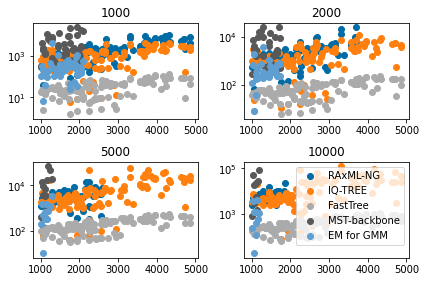

In [60]:
# scalability plots


from cProfile import label
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import numpy as np

from math import log

# Fixing random state for reproducibility

# x = np.arange(0.0, 50.0, 2.0)
# y = x ** 1.3 + np.random.rand(*x.shape) * 30.0
# sizes = np.random.rand(*x.shape) * 800 + 500

# fig, ax = plt.subplots()
# ax.scatter(x, y, sizes, c="green", alpha=0.5, marker=r'$\clubsuit$',
#            label="Luck")
# ax.set_xlabel("Leprechauns")
# ax.set_ylabel("Gold")
# ax.legend()

fig, ax = plt.subplots(2,2)
# gs = fig.add_gridspec(2, 2, hspace=2, wspace=2)
# fig, ((ax_fast, ax_mstbackbone), (ax_raxml, ax_iqtree)) = plt.subplots(2, 2)
i = 0
seq_len = 1000
method_colour = {}
method_colour['fasttree'] = 'black'
method_colour['raxmlng'] = 'pink'
method_colour['fasttree'] = 'black'
method_colour['fasttree'] = 'black'
# subplot_dic = {}
# subplot_dic['fasttree'] = ax_fast
# subplot_dic['mstbackbone'] = ax_mstbackbone
# subplot_dic['raxmlng'] = ax_raxml
# subplot_dic['iqtree'] = ax_iqtree
# method_list = ['fasttree', 'mstbackbone']
method_list = ['raxmlng','iqtree','fasttree','mstbackbone_unrooted','mstbackbone_rooted']
for method in method_list:
    for seq_len in seqlen_list:    
        # if method == 'fasttree':
        if seq_len == 1000:
            # ax_fast.subplot(2, 2, i)    
            ax[0, 0].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method)
            ax[0, 0].set_title(seq_len)
            # ax[0, 0].set_xscale("log")
            ax[0, 0].set_yscale("log")
        # elif method == 'mstbackbone':
        elif seq_len == 2000:
            # ax_mstbackbone.subplot(2, 2, i)    
            ax[0, 1].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method)            
            ax[0, 1].set_title(seq_len)
            # ax[0, 1].set_xscale("log")
            ax[0, 1].set_yscale("log")
        # elif method == 'raxmlng':
        elif seq_len == 5000:
            # ax_raxml.subplot(2, 2, i)    
            ax[1, 0].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method)
            ax[1, 0].set_title(seq_len)
            # ax[1, 0].set_xscale("log")
            ax[1, 0].set_yscale("log")
        # elif method == 'iqtree':
        elif seq_len == 10000:
            # ax_iqtree.plot(2, 2, i) 
            ax[1, 1].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method)
            ax[1, 1].set_title(seq_len)
            # ax[1, 1].set_xscale("log")
            ax[1, 1].set_yscale("log")
# ax.set_yscale("log")
fig.tight_layout(pad=1.0)
plt.legend(['RAxML-NG', 'IQ-TREE', 'FastTree','MST-backbone','EM for GMM'], loc ="upper right")
plt.show()
# plt.show()



45
1951


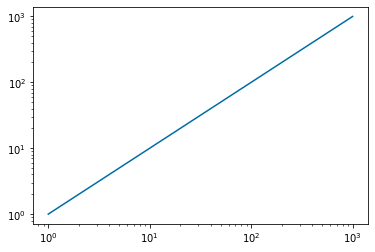

In [54]:
# Accuracy

def Get_accuracy(method,exp_id):
    # print(method, exp_id)
    runTime = -1
    if method == "raxmlng":
        log_file_name = projectPath + '/batch_scripts/RAxMLNG_' + exp_id + '.raxml.log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Elapsed time:'):
                runTime = float(line.strip().split('Elapsed time:')[1].split(' seconds')[0])                
    elif method == "mstbackbone_unrooted":        
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('CPU time used for computing global unrooted phylogenetic tree T is '):
                runTime = float(line.split('CPU time used for computing global unrooted phylogenetic tree T is ')[1].split(' second(s)')[0])
    elif method == "mstbackbone_rooted":        
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('CPU time used for rooting T using restriced SEM is '):
                runTime = float(line.split('CPU time used for rooting T using restriced SEM is ')[1].split(' second(s)')[0])
    elif method == "fasttree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_errlog'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total time: '):
                runTime = float(line.strip().split('Total time: ')[1].split(' seconds')[0])
    elif method == "iqtree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total CPU time used:'):
                runTime = float(line.split('Total CPU time used: ')[1].split(' sec')[0])

    log_file.close()
    return (runTime)


x = [i for i in range(1,1000)]
# fig, ax = plt.subplots(1,1)
plt.loglog(x,x)
# ax[0, 0].set_title(seq_len)

print(run_times_seq_len_method[1000]['mstbackbone_unrooted'].index(max(run_times_seq_len_method[1000]['mstbackbone_unrooted'])))

print(num_leaves_seq_len_method[1000]['mstbackbone_unrooted'][45])


In [40]:
# scalability plot (sequence length)

In [ ]:
# scalability plot (sequence length)